# Product Recommendation Systems

## Importing headers

In [ ]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install Surprise

     |████████████████████████████████| 11.8MB 269kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1615277 sha256=5b37e1483168e903fde43a9649cb39eef38255a56e2d19980f8170f5bf316904
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import surprise

## Extracting and exploring dataset

In [ ]:
!gdown --i 1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW

Downloading...
From: https://drive.google.com/uc?id=1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW
To: /content/ratings_Electronics.csv
319MB [00:03, 94.2MB/s]


In [ ]:
df=pd.read_csv('ratings_Electronics.csv', names=[ 'userId', 'productId', 'ratings', 'timestamp'])
df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


We drop the 'timestamp' column as it is not needed for our purposes.

In [ ]:
df=df.drop(['timestamp'],axis=1)
df.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [ ]:
(df.groupby('userId').size())

userId
A00000262KYZUE4J55XGL    1
A000063614T1OE0BUSKUT    2
A00009182QVLSWIGHLS1B    1
A00009661LC9LQPGKJ24G    1
A00010809P09NUU6ZP6H     1
                        ..
AZZZOVIBXHGDR            3
AZZZRS1YZ8HVP            2
AZZZSIK7NFFVP            1
AZZZWXXUPZ1F3            1
AZZZY1W55XHZR            1
Length: 4201696, dtype: int64

**Creating subset of the dataset**

We take a subset of the dataset to make it denser.

The array 'required_users' will store the  userId with 50 or more entries (ratings).

In [ ]:
required_users=df.groupby('userId').size().index.values[list(df.groupby('userId').size()>=50)]

In [ ]:
len(required_users)

1540

In [ ]:
required_users

array(['A100UD67AHFODS', 'A100WO06OQR8BQ', 'A105S56ODHGJEK', ...,
       'AZMY6E8B52L2T', 'AZNUHQSHZHSUE', 'AZOK5STV85FBJ'], dtype=object)

Using this array, we subset df into a new dataframe called 'required_df'.

In [ ]:
required_df=df[df['userId'].isin(required_users)]

Let's see the number of ratings given by all users.


In [ ]:
required_df.groupby('userId').size()

userId
A100UD67AHFODS    116
A100WO06OQR8BQ    132
A105S56ODHGJEK     68
A105TOJ6LTVMBG     71
A10AFVU66A79Y1     65
                 ... 
AZBXKUH4AIW3X      53
AZCE11PSTCH1L      60
AZMY6E8B52L2T     189
AZNUHQSHZHSUE      54
AZOK5STV85FBJ      54
Length: 1540, dtype: int64

We can see all these userIds have given equal to or more than 50 ratings.

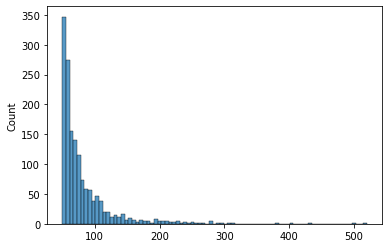

In [ ]:
sns.histplot(required_df.groupby('userId').size())

The above histogram shows the counts of ratings of particular productIds. 

More users have given less number of ratings. Few have given above 300 ratings.

In [ ]:
required_df.describe()

,ratings
count,125871.000000
mean,4.261339
std,1.062144
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


Due to majority of 5 ratings, the mean is very close to 5, i.e. 4.26.

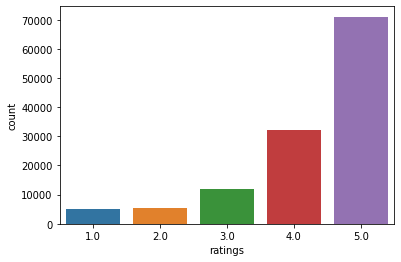

In [ ]:
sns.countplot(data=required_df, x="ratings")

With the above chart we can see that more people tend to give higher ratings.

In [ ]:
len(required_df.productId.unique())

48190

We can see there's a total of 48190 productIds.

In [ ]:
df.groupby('productId')['ratings'].count()

productId
0132793040     1
0321732944     1
0439886341     3
0511189877     6
0528881469    27
              ..
BT008G3W52     1
BT008SXQ4C     1
BT008T2BGK     1
BT008UKTMW    15
BT008V9J9U     1
Name: ratings, Length: 476002, dtype: int64

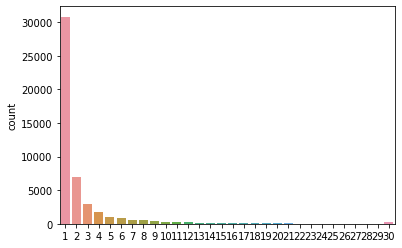

In [ ]:
sns.countplot(x=required_df.groupby('productId')['ratings'].count().clip(upper=30).tolist())

From the above chart, we can see that few products have many ratings.

## Recommendation Models

In [ ]:
df=required_df

### Popularity based recommendation

First we'll create a dataframe containing productId and their corresponnding number of ratings (ratings_count) and average rating received (avg_ratings).

In [ ]:
# Concatenating count and mean ratings
product_df=pd.concat([required_df.groupby('productId').count()['userId'],required_df.groupby('productId').mean('ratings')],axis=1)

# Converting index into keys (column names)
product_df=product_df.reset_index()

# Renaming column names
product_df=product_df.rename(columns={'userId':'ratings_count','ratings':'avg_ratings'})

product_df.head()

,productId,ratings_count,avg_ratings
0,0594451647,1,5.000000
1,0594481813,1,3.000000
2,0970407998,2,2.500000
3,0972683275,4,4.750000
4,1400501466,6,3.333333


For determining the popularity of a product, we'll use a weighted rating value for each product. 

We use the following formula to calculate the weighted average for every product:

`weighted_rating=(avg_ratings * ratings_count + mean_rating * count_cutoff)/(ratings_count + count_cutoff))`

First we take a cutoff for the number of ratings. 

In [ ]:
cutoff=0.95
product_df.quantile(cutoff)

ratings_count    9.0
avg_ratings      5.0
Name: 0.95, dtype: float64

We take that cutoff to be 0.95, which means that for a product to be popular, it must have more ratings than at least 95 % of the products.

In [ ]:
count_cutoff=product_df.quantile(cutoff)['ratings_count']
count_cutoff

9.0

Now we take the mean of the average ratings of the products.

In [ ]:
# Mean of avg_ratings

mean_rating=df['ratings'].mean()
mean_rating

4.26133898991825

Now we find the weighted rating of each product.

In [ ]:
product_df['weighted_rating']=product_df.apply(lambda row : (row['avg_ratings'] * row['ratings_count'] + mean_rating*count_cutoff)/(row['ratings_count']+count_cutoff), axis = 1)
product_df.head()

,productId,ratings_count,avg_ratings,weighted_rating
0,0594451647,1,5.000000,4.335205
1,0594481813,1,3.000000,4.135205
2,0970407998,2,2.500000,3.941096
3,0972683275,4,4.750000,4.411696
4,1400501466,6,3.333333,3.890137


We modify this dataframe and keep just the productId and the corresponding weighted rating in descending order.

In [ ]:
# Sorting in descending order with respect to weighted_rating. Also removing index.
product_ratings=product_df.sort_values('weighted_rating',ascending=False).reset_index(drop=True)

# Dropping columns ratings_count and avg_ratings
product_ratings=product_ratings.drop(['ratings_count','avg_ratings'],axis=1)

product_ratings.head(5)

,productId,weighted_rating
0,B0052SCU8U,4.868139
1,B003ES5ZUU,4.836021
2,B001TH7GUU,4.808644
3,B001TH7T2U,4.803103
4,B00BQ4F9ZA,4.802816


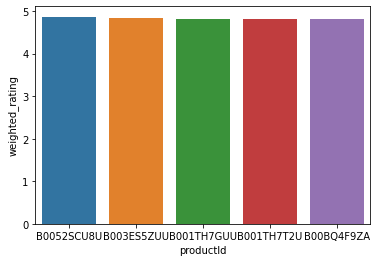

In [ ]:
sns.barplot(y=product_ratings.head(5)['weighted_rating'],x=product_ratings.head(5)['productId'])

These are the top 5 items as per weighted rating (popularity).

### Collaborative Filtering

We prepare the data as per requirements of surprise library.

In [ ]:
# Our rating scale is 1 to 5.

reader = surprise.Reader(rating_scale=(1, 5))
data = surprise.Dataset.load_from_df(df[['userId', 'productId', 'ratings']], reader)

We split the data into training set (70%) and testing set (30%).

In [ ]:
train_data, test_data = surprise.model_selection.train_test_split(data, test_size=0.3)

We'll use Singular value decomposition model which is a collaborative filtering method.

In [ ]:
model=surprise.SVD()
model.fit(train_data)

We make predictions using the test data and check the performance.

In [ ]:
predictions = model.test(test_data)
surprise.accuracy.rmse(predictions)

RMSE: 0.9805


0.9804987790692632

We can see we have a RMSE value of 0.98, overall nice performance.

In [ ]:
predictions[:10]

[Prediction(uid='AK3GKIV8DEY8B', iid='B0068LA636', r_ui=3.0, est=4.62150797495403, details={'was_impossible': False}),
 Prediction(uid='A6VPK7X53QNAQ', iid='B0017TFVUW', r_ui=4.0, est=3.241741569579996, details={'was_impossible': False}),
 Prediction(uid='A27H61OHW44XA7', iid='B001FA1NK0', r_ui=5.0, est=4.155396597779117, details={'was_impossible': False}),
 Prediction(uid='A3IUW081KXD3PE', iid='B003VANOI6', r_ui=5.0, est=4.338092117467701, details={'was_impossible': False}),
 Prediction(uid='A2KHG3JOFXQ4CE', iid='B0057OCDQS', r_ui=4.0, est=3.5699975906567607, details={'was_impossible': False}),
 Prediction(uid='A1K4G5YJDJQI6Q', iid='B002Q2M8KK', r_ui=4.0, est=2.6404563175989266, details={'was_impossible': False}),
 Prediction(uid='A11I1I9QLMAM1A', iid='B00IF4OATU', r_ui=5.0, est=4.404590586200711, details={'was_impossible': False}),
 Prediction(uid='AGXMC3ITWZASE', iid='B006JP2UXA', r_ui=5.0, est=3.9400753162482003, details={'was_impossible': False}),
 Prediction(uid='A4UGMKUSX9XHI', 

These are the first 10 prediction results.

Now, we make a dictionary which stores the top k recommendations of all the users.

We will take k=5.

In [ ]:
k=5

In [ ]:
# Creating the dictionary with all predictions.

top_k = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
  top_k[uid].append((iid, est))

In [ ]:
# Sort the predictions for each user and retrieve the k highest ones.

for uid, user_ratings in top_k.items():
  user_ratings.sort(key=lambda x: x[1], reverse=True)
  top_k[uid] = user_ratings[:k]

Now we'll check for a sample userId A100UD67AHFODS.

In [ ]:
user='A100UD67AHFODS'
top_k[user]

[('B00A83I8G2', 4.843121552853124),
 ('B0002SQ2P2', 4.7614989859364805),
 ('B0097BEF1S', 4.6616597339071495),
 ('B002NU5S02', 4.659598810339439),
 ('B0001D3K8A', 4.652097787898034)]

We can see the top 5 recommended productIds, along with the predicted ratings by the model. We can see the predicted ratings are in descending order.

### Summary of models

For the popularity based recommendation, we can see that it is a simple model and works on the concept of weighted average of the number of user ratings and the rating values. One challenge of this model is that it is not personalized to any user based on the user's interest/past activities'. Therefore, it is useful where a general recommendation has to be made for any user.

In collaborative filtering, the model learns the relation between the user and the ratings they gave for the products. Based on this learning, it tries to predict what another user with similar activities might prefer. Therefore, this method is useful where personalized recommendation is needed.